In [ ]:
# Project Setup
import sys, os, importlib
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Adding project root to path  
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Reloading modules (if needed) 
import fintech_roi_ai.preprocessing
import fintech_roi_ai.modeling
import fintech_roi_ai.evaluation

importlib.reload(fintech_roi_ai.preprocessing)
importlib.reload(fintech_roi_ai.modeling)
importlib.reload(fintech_roi_ai.evaluation)

# Importing custom functions
from fintech_roi_ai.preprocessing import stratified_split, preprocess_features 
from fintech_roi_ai.modeling import (
    train_logistic_regression,
    train_random_forest,
    train_gradient_boost
)
from fintech_roi_ai.evaluation import (
    get_classification_metrics,
    plot_confusion_matrix,
    plot_roc_curve
)

<module 'fintech_roi_ai.evaluation' from 'c:\\Users\\alexa\\OneDrive\\Desktop\\INST414_project\\alexa-inst414\\fintech_roi_ai\\evaluation.py'>

In [ ]:
# Load Dataset
df = pd.read_csv("../data/processed/telco_cleaned.csv")

# Quick Sanity Check
print("Data Shape:", df.shape)
print("\nTarget Distribution (Original):")
print(df['Churn'].value_counts(normalize=True))

df.head()

Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [ ]:
# Run the Split
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split(df, "Churn")
print("Split sizes:", len(X_train), len(X_val), len(X_test))

# Check Proportions & Stratification
total = len(df)
print("\n--- 1. SPLIT PROPORTIONS (Target: 70% / 15% / 15%) ---")
print(f"Training Set:   {len(X_train)} rows ({len(X_train)/total:.1%})")
print(f"Validation Set: {len(X_val)} rows ({len(X_val)/total:.1%})")
print(f"Testing Set:    {len(X_test)} rows ({len(X_test)/total:.1%})")

print("\n--- 2. STRATIFICATION CHECK (Target: ~0.266 everywhere) ---")

# Check means before converting to numbers
print(f"Original Churn Rate:   {df['Churn'].map({'Yes':1, 'No':0}).mean():.4f}")
print(f"Training Churn Rate:   {y_train.map({'Yes':1, 'No':0}).mean():.4f}")
print(f"Validation Churn Rate: {y_val.map({'Yes':1, 'No':0}).mean():.4f}")
print(f"Testing Churn Rate:    {y_test.map({'Yes':1, 'No':0}).mean():.4f}")

# Final Conversion to Numeric (0/1)
y_train = y_train.map({"No": 0, "Yes": 1})
y_val   = y_val.map({"No": 0, "Yes": 1})
y_test  = y_test.map({"No": 0, "Yes": 1})

Split sizes: 4922 1055 1055
--- 1. SPLIT PROPORTIONS (Target: 70% / 15% / 15%) ---
Training Set:   4922 rows (70.0%)
Validation Set: 1055 rows (15.0%)
Testing Set:    1055 rows (15.0%)

--- 2. STRATIFICATION CHECK (Target: ~0.266 everywhere) ---
Original Churn Rate:   0.2658
Training Churn Rate:   0.2657
Validation Churn Rate: 0.2664
Testing Churn Rate:    0.2654


In [ ]:
# Feature Preprocessing
# Define numerical columns to scale
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"] 

# Double check they exist 
actual_num_cols = [c for c in num_cols if c in X_train.columns]

# Run Preprocessing
X_train_enc, X_val_enc, X_test_enc = preprocess_features(
    X_train, X_val, X_test, numerical_cols=actual_num_cols
)

print("Preprocessing Complete.")
print(f"Original Columns: {X_train.shape[1]}")
print(f"Encoded Columns:  {X_train_enc.shape[1]}")

Encoded shapes: (4922, 30) (1055, 30) (1055, 30)


In [ ]:
# Training Models 
print("--- Starting Training ---")

# 1. Logistic Regression
start = time.time()
log_model = train_logistic_regression(X_train_enc, y_train)
log_time = time.time() - start
print(f"Logistic Regression trained in: {log_time:.4f} sec")

# 2. Random Forest
start = time.time()
rf_model = train_random_forest(X_train_enc, y_train)
rf_time = time.time() - start
print(f"Random Forest trained in:       {rf_time:.4f} sec")

# 3. Gradient Boosting
start = time.time()
gb_model = train_gradient_boost(X_train_enc, y_train)
gb_time = time.time() - start
print(f"Gradient Boosting trained in:   {gb_time:.4f} sec")


Logistic Regression training time: 0.21770095825195312
Random Forest training time: 1.1271615028381348
Gradient Boosting training time: 1.0260968208312988


In [ ]:
# Validation Metrics
metrics_log = get_classification_metrics(log_model, X_val_enc, y_val)
metrics_rf  = get_classification_metrics(rf_model,  X_val_enc, y_val)
metrics_gb  = get_classification_metrics(gb_model,  X_val_enc, y_val)

print("\nLogistic Regression:\n", metrics_log)
print("\nRandom Forest:\n", metrics_rf)
print("\nGradient Boosting:\n", metrics_gb)

Logistic Regression Metrics: {'accuracy': 0.747867298578199, 'precision': 0.5170068027210885, 'recall': 0.8113879003558719, 'f1': 0.631578947368421, 'auc': 0.8531660643512005}
Random Forest Metrics: {'accuracy': 0.7943127962085308, 'precision': 0.6495327102803738, 'recall': 0.49466192170818507, 'f1': 0.5616161616161616, 'auc': 0.8267423469153171}
Gradient Boosting Metrics: {'accuracy': 0.8018957345971564, 'precision': 0.6875, 'recall': 0.4697508896797153, 'f1': 0.5581395348837209, 'auc': 0.8527982381123157}
Baseline Accuracy: 0.7336492890995261
Baseline Precision: 0.0
Baseline Recall: 0.0
Baseline F1: 0.0
Logistic Regression - TRAIN: {'accuracy': 0.7545713124746039, 'precision': 0.5246791707798618, 'recall': 0.8126911314984709, 'f1': 0.6376724655068986, 'auc': 0.8517647773101209}
Random Forest - TRAIN: {'accuracy': 0.9987809833401057, 'precision': 0.9969465648854962, 'recall': 0.9984709480122325, 'f1': 0.9977081741787625, 'auc': 0.9999888938531603}
Gradient Boosting - TRAIN: {'accuracy

In [ ]:
# Baseline Comparison
# Predict "0" (No Churn) for everyone
baseline_pred = [0] * len(y_val)

base_acc = accuracy_score(y_val, baseline_pred)
base_rec = recall_score(y_val, baseline_pred, pos_label=1, zero_division=0)
base_f1  = f1_score(y_val, baseline_pred, pos_label=1, zero_division=0)

print(f"Baseline Accuracy: {base_acc:.4f}")
print(f"Baseline Recall:   {base_rec:.4f}")
print(f"Baseline F1:       {base_f1:.4f}")

In [ ]:
# Overfitting Check
metrics_log_train = get_classification_metrics(log_model, X_train_enc, y_train)
metrics_rf_train  = get_classification_metrics(rf_model,  X_train_enc, y_train)
metrics_gb_train  = get_classification_metrics(gb_model,  X_train_enc, y_train)

print("\nLogistic Regression (Train):\n", metrics_log_train)
print("\nRandom Forest (Train):\n", metrics_rf_train)
print("\nGradient Boosting (Train):\n", metrics_gb_train)

In [ ]:
# Global Plotting Style 
plt.style.use("seaborn-v0_8-colorblind")

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "figure.dpi": 150,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

C:\Users\alexa\AppData\Local\Temp\ipykernel_46264\978837231.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")


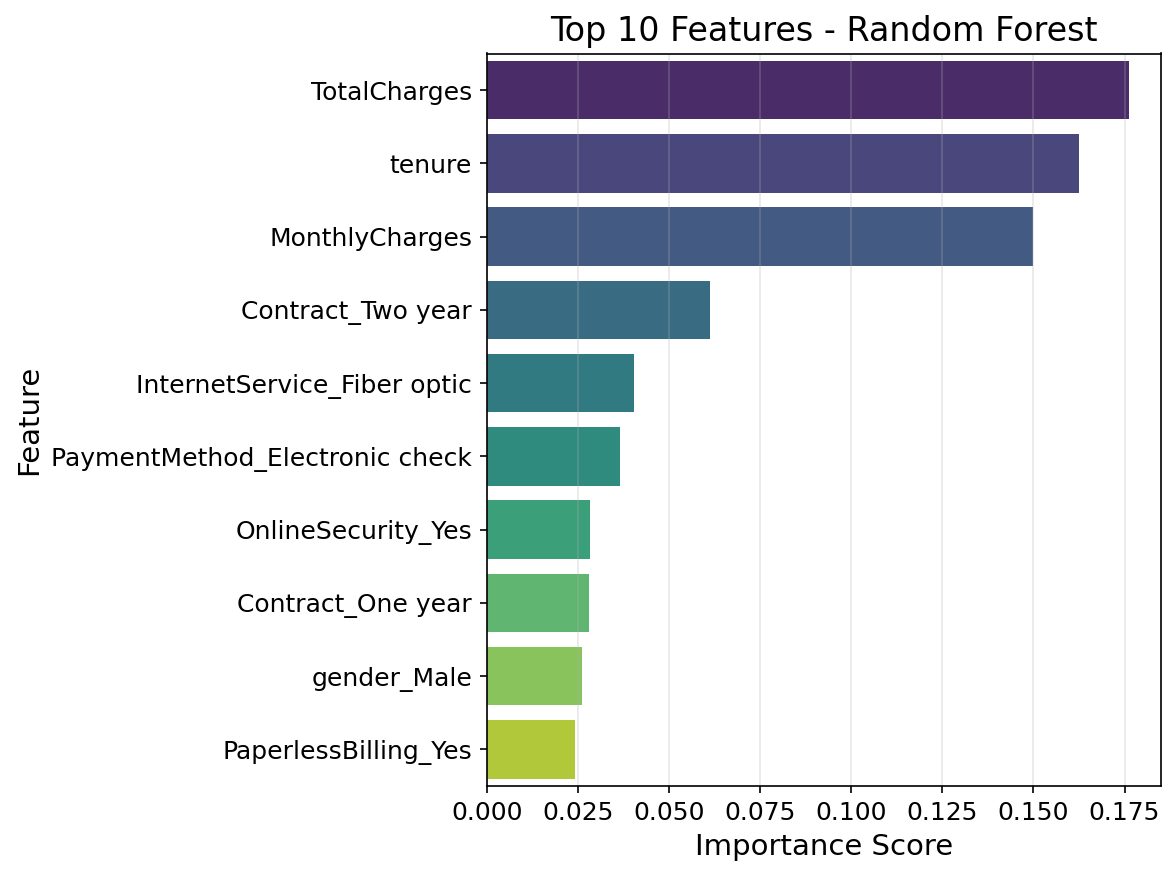

C:\Users\alexa\AppData\Local\Temp\ipykernel_46264\978837231.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")


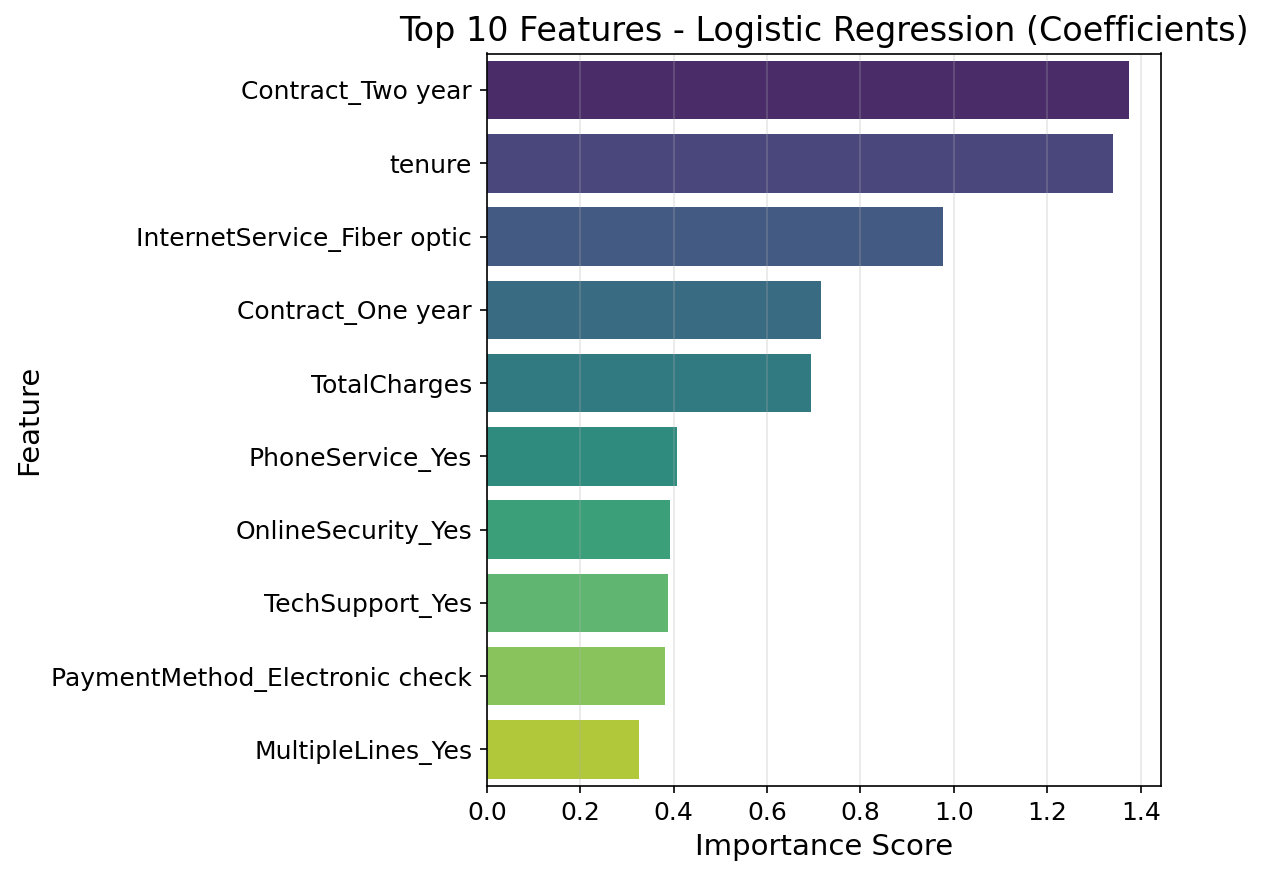

In [ ]:
# Feature Importance Figure
def plot_feature_importance(model, feature_names, model_name, top_n=10):
    # 1. Get Importances (handling different model types)
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0]) # Take absolute value for magnitude
    else:
        print(f"Model {model_name} does not have feature importances.")
        return

    # 2. Create DataFrame
    feat_imp = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).head(top_n)

    # 3. Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
    plt.title(f"Top {top_n} Features - {model_name}")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Get feature names from your encoded dataframe
feature_cols = X_train_enc.columns

# Plots
plot_feature_importance(rf_model, feature_cols, "Random Forest")
plot_feature_importance(log_model, feature_cols, "Logistic Regression (Coefficients)")

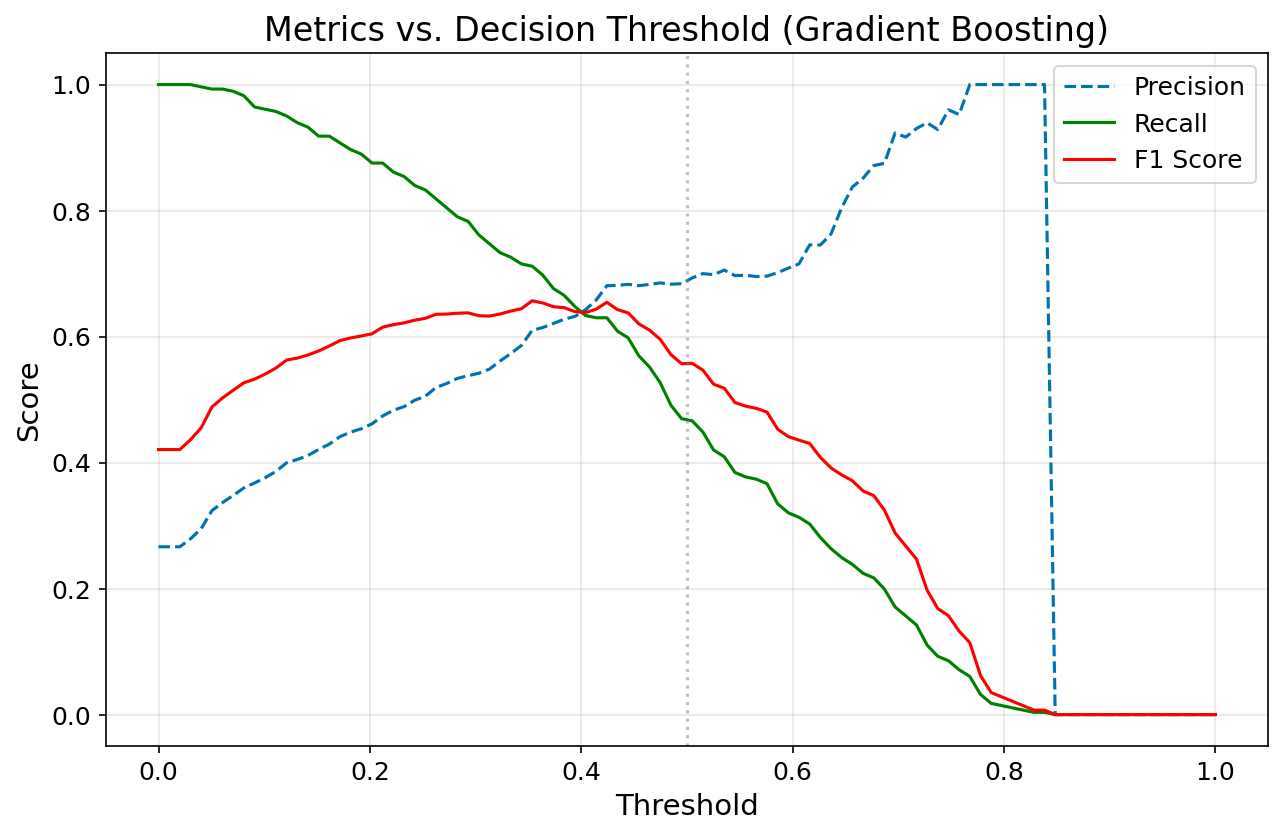

In [16]:
# Section 3a. Threshold
def plot_precision_recall_vs_threshold(model, X_val, y_val):
    y_probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    f1s = []

    for t in thresholds:
        y_pred_t = (y_probs >= t).astype(int)
        precisions.append(precision_score(y_val, y_pred_t, zero_division=0))
        recalls.append(recall_score(y_val, y_pred_t, zero_division=0))
        f1s.append(f1_score(y_val, y_pred_t, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", linestyle="--")
    plt.plot(thresholds, recalls, label="Recall", color="green")
    plt.plot(thresholds, f1s, label="F1 Score", color="red")
    
    # Highlight the 0.5 default
    plt.axvline(0.5, color='gray', alpha=0.5, linestyle=':')
    
    plt.title("Metrics vs. Decision Threshold (Gradient Boosting)")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run this on your best model (likely Gradient Boosting or LogReg)
plot_precision_recall_vs_threshold(gb_model, X_val_enc, y_val)

<Figure size 1500x900 with 0 Axes>

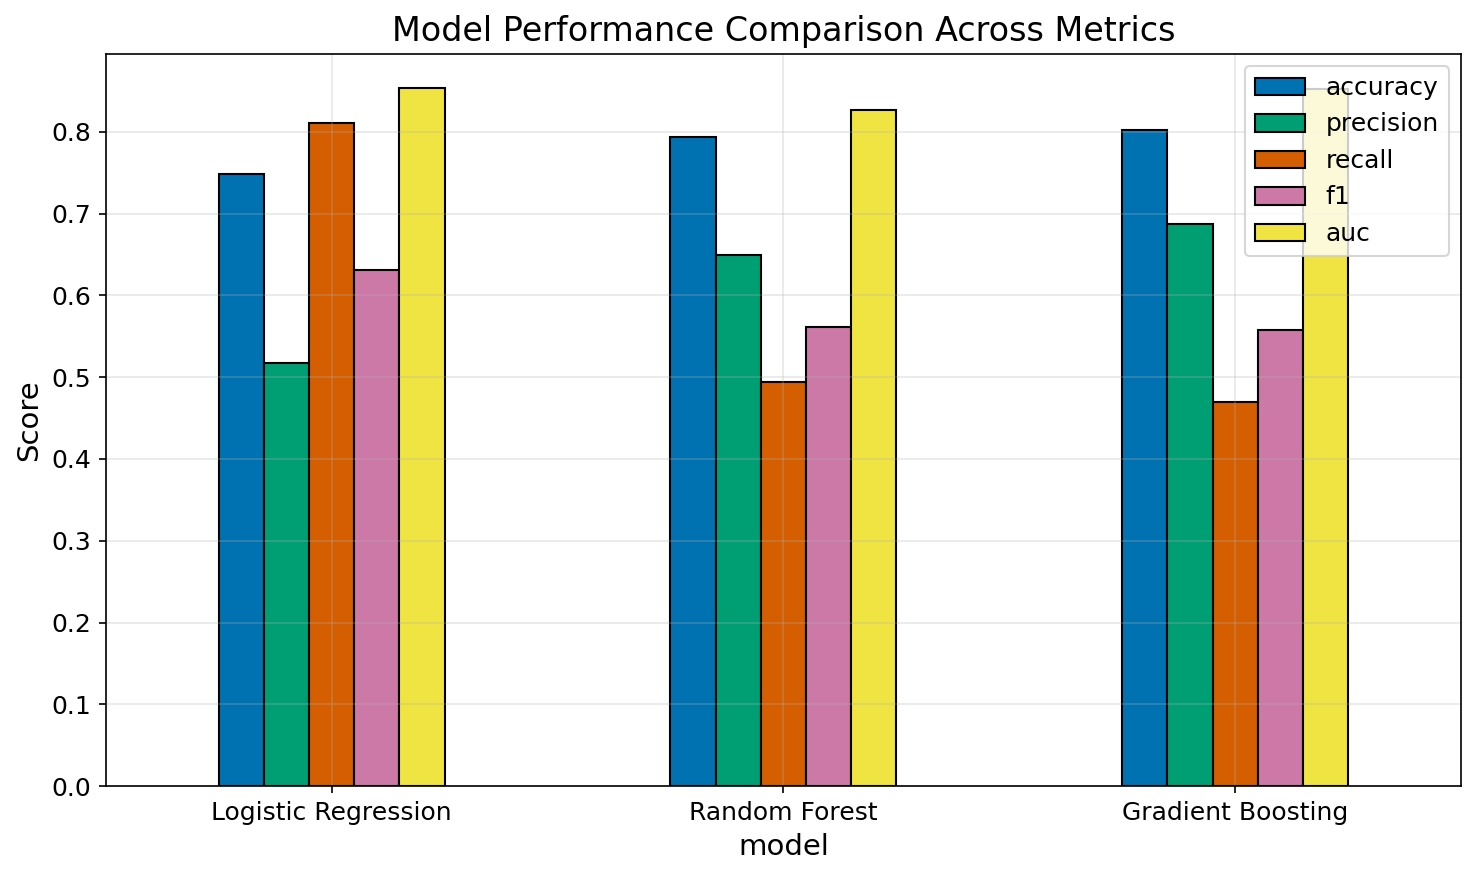

In [10]:
# Model Performance Comparison (Figure)
metrics_df = pd.DataFrame([
    {"model": "Logistic Regression", **metrics_log},
    {"model": "Random Forest",       **metrics_rf},
    {"model": "Gradient Boosting",   **metrics_gb},
])

metrics_df.set_index("model", inplace=True)

plt.figure(figsize=(10,6))
metrics_df.plot(kind="bar", edgecolor="black", figsize=(10,6))
plt.title("Model Performance Comparison Across Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()

plt.savefig("../reports/figures/model_comparison.png", dpi=300)
plt.show()

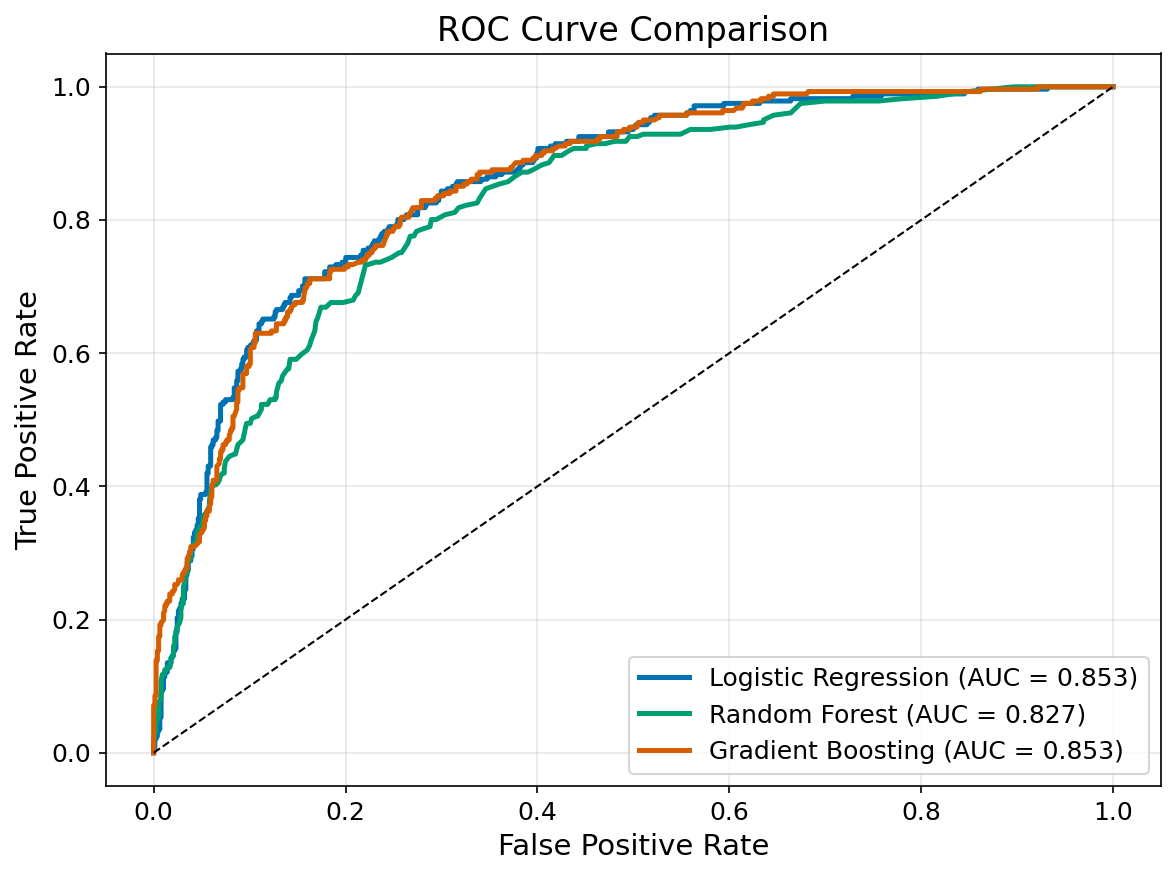

In [11]:
# Combined ROC Curve Comparison (Figure)
from sklearn.metrics import roc_curve, auc

models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(X_val_enc)[:,1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2.4, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--", linewidth=1)

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()

plt.savefig("../reports/figures/roc_comparison.png", dpi=300)
plt.show()


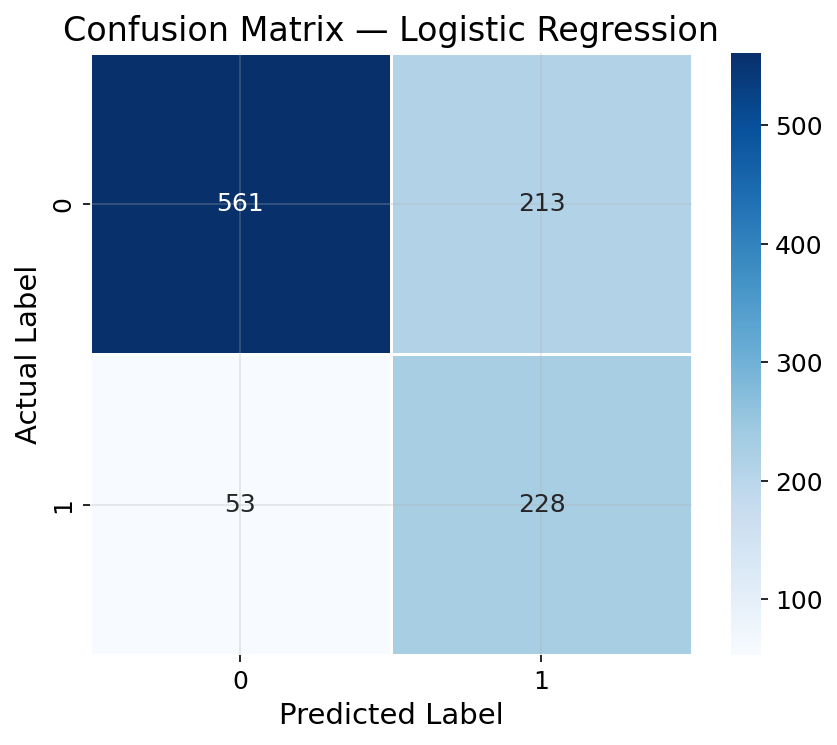

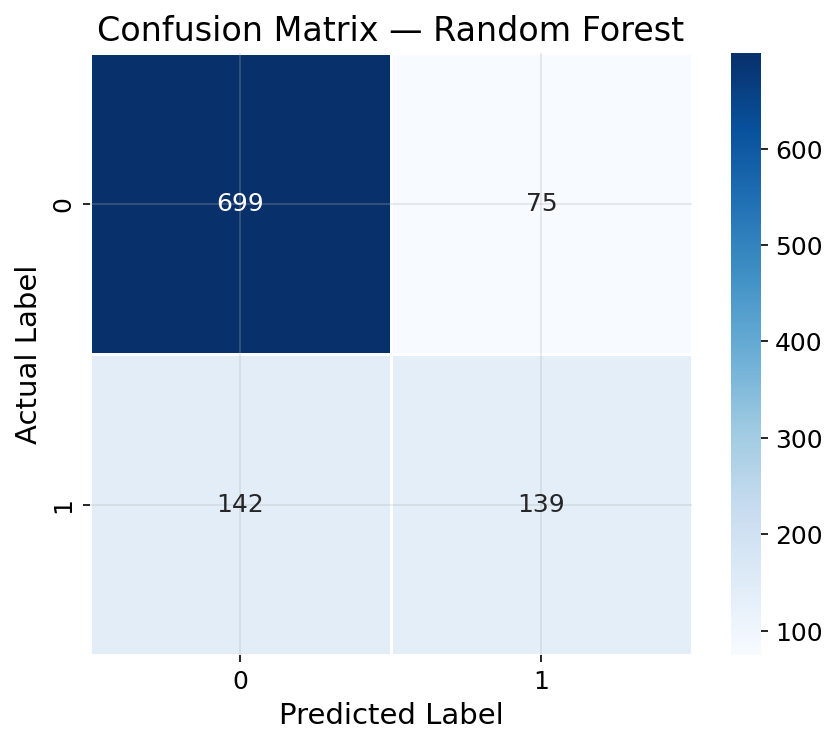

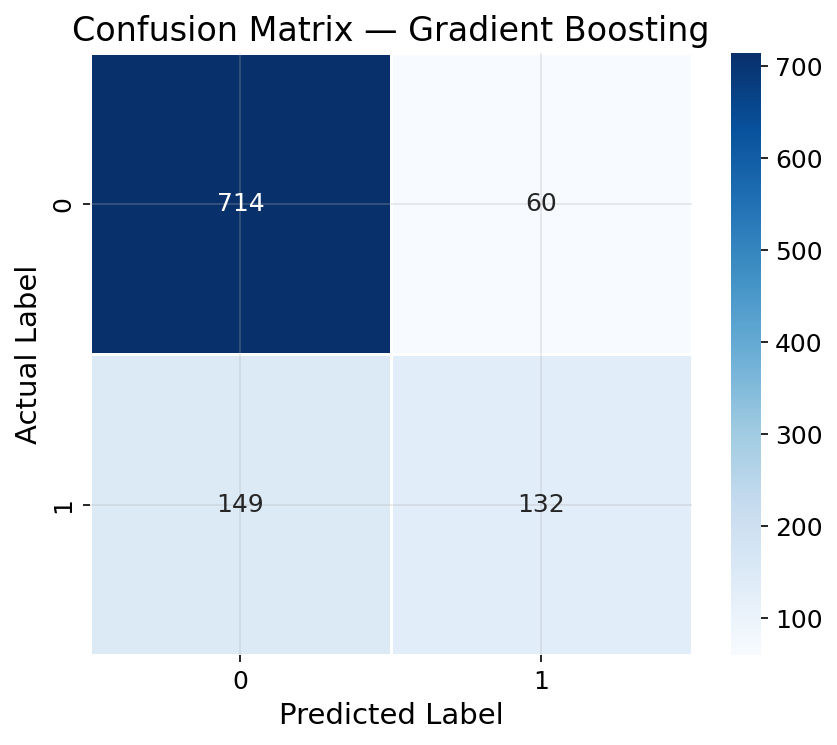

In [ ]:
from sklearn.metrics import confusion_matrix

models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}

for name, model in models.items():
    cm = confusion_matrix(y_val, model.predict(X_val_enc))

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=0.5,
        linecolor="white",
        square=True
    )
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.tight_layout()

    plt.savefig(f"../reports/figures/confusion_matrix_{name.replace(' ', '_').lower()}.png", dpi=300)
    plt.show()


In [13]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Dictionary of models
models = {
    "Logistic Regression": log_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}

# Store results
rows = []

for name, model in models.items():
    y_pred = model.predict(X_val_enc)
    cm = confusion_matrix(y_val, y_pred)

    tn, fp, fn, tp = cm.ravel()

    rows.append({
        "Model": name,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    })

# Convert to dataframe
cm_table = pd.DataFrame(rows)

print(cm_table)


                 Model   TN   FP   FN   TP
0  Logistic Regression  561  213   53  228
1        Random Forest  699   75  142  139
2    Gradient Boosting  714   60  149  132


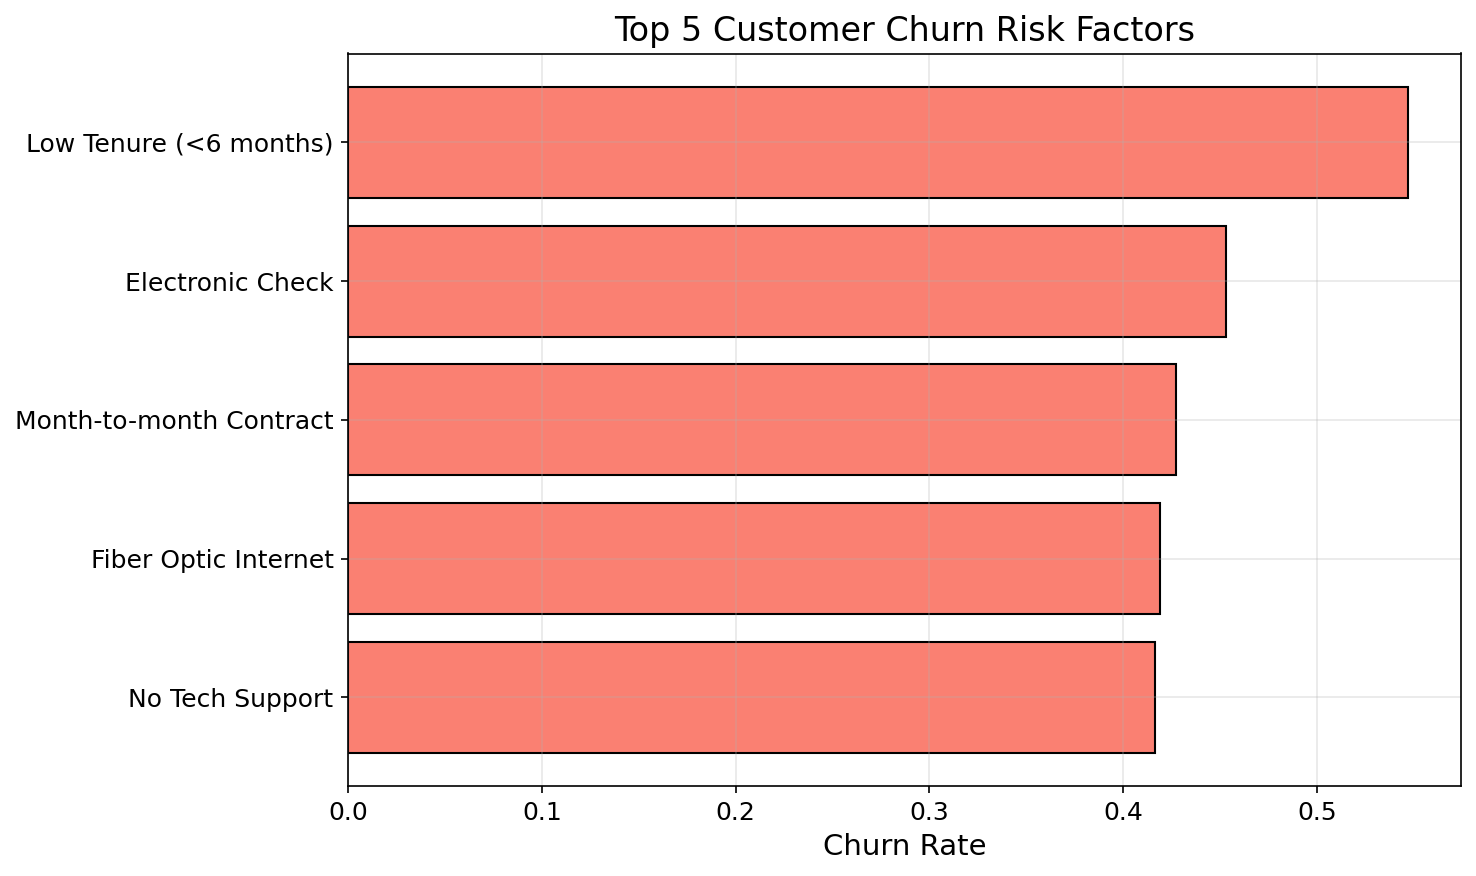

In [17]:
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})

summary = {
    "Month-to-month Contract": df[df["Contract"]=="Month-to-month"]["Churn_numeric"].mean(),
    "Fiber Optic Internet": df[df["InternetService"]=="Fiber optic"]["Churn_numeric"].mean(),
    "No Tech Support": df[df["TechSupport"]=="No"]["Churn_numeric"].mean(),
    "Electronic Check": df[df["PaymentMethod"]=="Electronic check"]["Churn_numeric"].mean(),
    "Low Tenure (<6 months)": df[df["tenure"] < 6]["Churn_numeric"].mean()
}

risk_df = pd.DataFrame.from_dict(summary, orient='index', columns=["ChurnRate"])
risk_df = risk_df.sort_values("ChurnRate", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(risk_df.index, risk_df["ChurnRate"], color="salmon", edgecolor="black")
plt.xlabel("Churn Rate")
plt.title("Top 5 Customer Churn Risk Factors")
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig("../reports/figures/domain_risk_factors.png", dpi=300)
plt.show()